# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
%pip install -qU numpy matplotlib plotly pandas scipy scikit-learn openai python-dotenv PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [2]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [4]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [5]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [6]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [7]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [8]:
# I HAVE COMMENTED THIS OUT BECAUSE MY KEYS ARE EXPORTED IN MY LOCAL ENVIRONMENT.
# import os
import openai
# from getpass import getpass

# openai.api_key = getpass("OpenAI API Key: ")
# os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
2. What technique does OpenAI use to achieve this?

---
### ANSWER #1:

1.  When creating the embedding, the current code provides the input and model arguments, but we can add a dimension argument that will reduce the dimension below 1536. For example, this code would reduce the dimensionality to 192:
```python
def get_embedding(self, text: str) -> List[float]:
    embedding = self.client.embeddings.create(
        input=text, model=self.embeddings_model_name, dimensions=192
    )
    return embedding.data[0].embedding
 ```

2.  OpenAI trained `text-embedding-3-small` and `text-embedding-3-large` using Matryoshka Representation Learning.  This technique creates an embedding vector that is essentially sorted from coarser to finer granularity. (Think of the Russian dolls!) At implementation time, this can be leveraged with adaptive retrieval.  Aside from adaptive retrieval, the main potential advantages of reducing the dimensionality are a lower footprint for the vector index, and reduced compute requirements during inference.   
---

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [9]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

---
### ANSWER #2:

Synchronous methods block execution until they have completed and this is disadvantageous when making calls to a server, for example.  In our case, we are getting embeddings from OpenAI, which means we are making HTTP calls (under the hood).  By making the methods asynchronous by using `async def` then we are making the method non-blocking;  the calling code uses `await` in front of the method call, but the program can continue to execute other events.  Essentially, in the `EmbeddingModel` class, the `async_get_embedding(s)` methods are defined as asynchronous.  In our `VectorDatabase` class, `abuild_from_list` (also defined as asynchronous) calls the methods in the `EmbeddingModel` class, preceding the call with the keyword `await`.

To provide an overall event loop to manage these asynchronous calls and provide , we initiate the processes by using the `asyncio` library as was done in the code:

```python
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))
```

 At the top level of our script or program, we MUST use `asyncio.run()` or we will get a `RuntimeError`.

---


So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [10]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=5)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

---
### Answer #3:

The content of the prompt will affect the "quality" of response with respect to what we are trying to achieve, but I interpret this question to relate to getting more reproducible outputs for any prompt, regardless of whether the prompt is optimized for the task.  The parameter that immediately comes to mind is temperature, but there are several others:

1.  Temperature - This is a value from 0 to 2 that controls randomness of selection for the next token.  If the temperature is set to zero, the next token will be greedily selected based on order of probability;  in practice, SOME randomness is introduced to prevent LLMs from going into repetitive loops, etc.  Increasing temperature increases randomness and for some purposes, enriches the potential responses of the model.  Decreasing the temperature reduces randomness to a minimum.  This obviously should enhance reproducibility.
2.  Top P - This controls the fraction of likelihood based options that will be available for the model to consider when it samples the probability distribution and selects the next token.  Reducing this will increase reproducibility since the model will have a smaller probability distribution from which to select the next token.
3.  Frequency penalty - This is designed to prevent the model from using the same tokens over and over, similar to what I mentioned above about having a zero temperature leading to loops and repetitions.  Increasing this penalty will encourage the model to use different tokens than are already in the response (based on frequency), which will reduce reproducibility.
4.  Presence penalty - similar to frequency penalty except focuses on whether a token has appeared in the text so far (yes or no) rather than the frequency of the token in the existing text.

As I understand this, you would not alter these latter three parameters if you are also manipulating temperature, and changing temperature is generally the way reproducibility is tweaked by users.  Changing the other parameters might be useful in very special use cases.

---

### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [11]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [12]:
print(response)

The best way to write a loop in Python depends on your specific use case and what you want to achieve. However, here are some general tips and examples for some common looping structures in Python:

### 1. Using `for` loops
The `for` loop is useful for iterating over items in a collection (like a list, tuple, or string).

```python
# Example: Looping through a list
fruits = ['apple', 'banana', 'cherry']
for fruit in fruits:
    print(f"I like {fruit}")
```

### 2. Using `while` loops
The `while` loop is great when you want to repeat a block of code as long as a condition is true.

```python
# Example: Looping until a condition is met
count = 0
while count < 5:
    print(f"Count is: {count}")
    count += 1  # Don't forget to update the condition!
```

### 3. Using list comprehensions
If you want to create a new list by applying an expression to each item in an existing list, you can use a list comprehension, which is often more concise than a traditional loop.

```python
# Example: Cre

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [13]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through the Week 1 Day 1 "Prompting OpenAI Like A Developer" material for an answer to this question!

---
### ANSWER #4:

One approach is to provide  one-shot or few-shot examples that demonstrate what you want the model to do.  Another approach is to tell the model to think through the problem step by step, or to explain its response.  Both of these are examples of "Chain of Thought (COT) Prompting".

---

In [14]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [15]:
retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to a situation where a CEO or startup founder, who has a strong background in a specific function (such as product management, sales, or marketing), hires a weak executive to run that same function. This happens because the leader may struggle to let go of the role that initially contributed to their success and may choose to hire someone less competent to maintain control and be seen as the primary authority in that area. The term is derived from Michael Eisner, the former CEO of Disney, who faced challenges in running ABC after acquiring it, expressing confidence in his ability to turn it around, despite lacking the necessary time and possibly overlooking the importance of strong leadership in that function.",
 'context': [('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happ

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

---
### Activity Description 
- I altered text_utils.py by adding a new class to load PDF documents (PDFLoader).
- I added a PDF to the data folder in the Day 2 folder;  this paper describes an adaptive clinical trial studying platelets in surgical patients.  
- I used a naive splitter (CharacterTextSplitter) but altered the chunk parameters
- I created a pipeline to ask questions
- I established a question that couldn't be answered, added COT, and then it was answered correctly.


#### Load the PDF document

In [16]:
# Import my PDFLoader class 
from aimakerspace.text_utils import PDFLoader
pdf_loader = PDFLoader("data/Krachey.pdf")
documents = pdf_loader.load_documents()
print("First 500 characters: \n" + documents[0][:500]+"\n\n")
print("Final 500 characters: \n" + documents[0][-500:])

First 500 characters: 
The design of an adaptive clinical trial to evaluate the efficacy of
platelets stored at low temperature in surgical patients
Elizabeth Krachey, PhD, Kert Viele, PhD, Philip C. Spinella, MD, Marie E. Steiner, MD,
Nicole D. Zantek, MD, PhD, andRoger J. Lewis, MD, PhD , Los Angeles, California
BACKGROUND: Storage of platelets at 4°C compared with 22°C may increase both hemosta tic activity and storage duration; however, the maximum duration of
cold storage is unknown. We report the design of an in


Final 500 characters: 
, Lewis RJ. Gatekeeping strategies for avoiding false-positive results
in clinical trials with many comparisons. JAMA . 2017;318:1385 –1386.
31. Corash L. Bacterial contamination of platelet components: potential solu-
tions to prevent transfusion-related sepsis. Expert Rev Hematol . 2011;4:
509–525.Krachey et al.J Trauma Acute Care Surg
Volume 84, Number 6, Supplement 1
S46 © 2018 Wolters Kluwer Health, Inc. All rights reserved.
Copyright © 2018 

#### Naive approach - use CharacterTextSplitter

In [17]:
# text_splitter = CharacterTextSplitter()
# Let's use a smaller chunk size
text_splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=400)
split_documents = text_splitter.split_texts(documents)
print("Number of chunks: " + str(len(split_documents)))
print("\nFirst chunk: \n" + split_documents[0])

Number of chunks: 88

First chunk: 
The design of an adaptive clinical trial to evaluate the efficacy of
platelets stored at low temperature in surgical patients
Elizabeth Krachey, PhD, Kert Viele, PhD, Philip C. Spinella, MD, Marie E. Steiner, MD,
Nicole D. Zantek, MD, PhD, andRoger J. Lewis, MD, PhD , Los Angeles, California
BACKGROUND: Storage of platelets at 4°C compared with 22°C may increase both hemosta tic activity and storage duration; however, the maximum duration of
cold storage is unknown. We report the design of an innovative, prospective, randomized, Bayesian adaptive, “duration finding ”clinical trial to
evaluate the efficacy and maximum duration of storage of platelets at 4°C.
METHODS: Patients undergoing cardiac surgery and requiring platelet transfusions will be enrolled. Patients will be randomized to rece


#### Build my vector store and test retrieval

In [18]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))
vector_db.search_by_text("What is DCR?", k=3)

[('ic causes.\nDamage Control Resuscitation (DCR) practices have been\ndeveloped to reduce death from hemorrhagic shock.\n3,4The DCR\nprinciples have been generalized to many nontrauma populations\nwith life-threatening bleeding, such as obstetric,5gastrointestinal,6\nand operative patients.7Perioperative bleeding in cardiac surgery\ncan be significant and is associated with poor outcomes.8–13A cen-\ntral tenant of DCR is hemostatic resuscitation, which aims to usewhole blood or its equivalent in components to provide a balanced\napproach to simultaneously address both oxygen debt and hemo-\nstatic dysfunction. Platelet tran sfusions are a key component of this\nstrategy; however, platelet availability is hampered by the relativelybrief maximum duration of storage that is safe at 22°C.\nTo address this c',
  np.float64(0.4504315482195112)),
 ('nant of DCR is hemostatic resuscitation, which aims to usewhole blood or its equivalent in components to provide a balanced\napproach to simulta

#### Time to feed the model!

In [20]:
RAG_PROMPT_TEMPLATE = """ \
You are an expert on clinical trials.  Use the provided context to answer the user's query.
You cannot answer if there is no specific information in the context.

If you do not know the answer or cannot answer, please respond with "I don't know".

Return your response in Markdown.
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""

user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

# Make my own pipeline
class MikeDeanRAGPipeline:
    def __init__(self,
                 llm:ChatOpenAI(), 
                 retriever:VectorDatabase) -> None:
        self.llm = llm
        self.retriever = retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.retriever.search_by_text(user_query, k=5)
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n" 
        formatted_system_prompt = rag_prompt.create_message()
        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)
        return self.llm.run([formatted_system_prompt, formatted_user_prompt])
        

In [21]:
from IPython.display import Markdown, display
my_pipeline = MikeDeanRAGPipeline(
    llm=chat_openai,
    retriever=vector_db
)

def askQuestion(question:str):
    display(Markdown(my_pipeline.run_pipeline(question)))

In [22]:
askQuestion("What are the inclusion and exclusion criteria?")

### Inclusion Criteria
- Patients undergoing cardiac surgery using cardiopulmonary bypass.
- Patients who entail a high risk for platelet transfusion.
- Patients on antiplatelet therapies.

### Exclusion Criteria
- Contentious objection or unwillingness to receive blood products.
- Transfusion of platelets or whole blood within 12 hours of randomization.
- Requirement for special platelet products (e.g., HLA-matched or cross-matched platelets).
- Presence of antibodies to platelets (e.g., anti-HP A-1a).
- Congenital platelet disorder.
- IgA deficiency.
- Pregnancy.
- Unavailability of the platelet supply for both arms of the study.
- Anticipation of the need for massive transfusion.

In [24]:
askQuestion("What patients can be included in the trial?")

I don't know.

#### Add Chain of Thought

In [25]:
RAG_PROMPT_TEMPLATE = """ \
You are an expert on clinical trials.  Use the provided context to answer the user's query.
You cannot answer if there is no specific information in the context.
Think step by step before answering the question.

If you do not know the answer or cannot answer, please respond with "I don't know".

Return your response in Markdown.
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

In [26]:
askQuestion("What patients can be included in the trial?")

Based on the provided context, the patients that can be included in the trial are cardiac surgery patients. Additionally, the data generated in this trial may be generalizable to other patient populations with life-threatening hemorrhage, which includes patients with traumatic injury, gastrointestinal bleeding, and obstetric bleeding.

In [27]:
askQuestion("What is the weather condition that involves water?")

I don't know.

In [28]:
askQuestion("Summarize the statistical design.")

## Summary of the Statistical Design

The statistical design outlined involves an adaptive clinical trial aimed at determining the maximum duration for which platelets can be stored at 4°C while maintaining hemostatic efficacy that is clinically comparable or superior to storage at 22°C for up to 5 days. 

### Key Components:

1. **Monte Carlo Simulation**:
   - The design process used Monte Carlo computer simulations to generate virtual trials under different scenarios (A, B, and C) to evaluate performance metrics such as type I error rate, power, required sample size, and accuracy in identifying the maximum noninferior duration of cold storage.
   - Each scenario simulates 10,000 virtual trials, with increased simulations (up to 100,000 for the null scenario) for better accuracy in identifying success thresholds.

2. **Iterative Process**:
   - The design was developed through a collaborative approach involving clinical, blood banking, and statistical experts. 
   - The process was iterative, allowing for the comparison of potential designs, selection of promising designs, modification of approaches, and further simulations based on trial performance.

3. **Operating Characteristics**:
   - The simulation allowed the assessment of probability distributions related to hemostatic efficacy across various platelet storage options, as well as the likelihood of achieving the maximum noninferior storage duration.
   - The simulation outcomes guide adaptations in the trial design, increasing the probability of trial success and avoiding continuation in futile cases.

4. **Trade-off Considerations**:
   - The design process considers the balance between desired trial performance, logistical constraints, and resource limitations, managing trade-offs between competing trial goals.

### Conclusion:
The statistical design pursues a well-defined framework for adaptive trials, allowing flexibility based on ongoing simulation results, and aims to derive meaningful conclusions about platelet storage efficacy within predefined clinical contexts.

In [29]:
askQuestion("What are the operating characteristics?  Be detailed in your answer.")

The operating characteristics refer to the statistical performance metrics evaluated through Monte Carlo simulations in the context of the clinical trial. Here is a detailed breakdown of these characteristics based on the provided context:

1. **Simulation of Trials**: 
   - For each of the three scenarios (A, B, and C), 10,000 virtual trials were simulated to evaluate the outcomes. 
   - In the null scenario (Scenario A), the number of simulations was increased to 100,000 to ensure a more accurate identification of the success threshold that maintains a type I error rate of 0.025.

2. **Purpose of Simulation**: 
   - The simulations were designed to represent various potential paths through the trial, capturing the probability of each outcome of interest based on the specific scenario.
   - The trials assessed conditions where platelets stored at different durations (4°C vs. 22°C) might show noninferiority or superiority in hemostatic efficacy.

3. **Described Scenarios**:
   - **Scenario A**: All dose durations are within the noninferiority margin (NIM). This serves as a baseline or null scenario.
   - **Scenario B**: Increasing durations of cold storage lose some effectiveness, but remain well within the NIM. This scenario helps examine the effects of varying durations while still being favorable.
   - **Scenario C**: A more challenging scenario where shorter storage durations (5-day and 10-day) show adequate performance, but the 15-day duration is inferior. This helps in understanding the limits of storage efficacy.

4. **Key Metrics**:
   - The **type I error rate** is maintained at 0.025, a critical element in determining the success of the trial design.
   - The **power** of the trial, which represents the probability of correctly rejecting a false null hypothesis, is evaluated to ensure statistical efficiency.
   - The **sample size** needed for the trial is also determined to optimize the design.

5. **Outcome Estimation**: 
   - The aggregate results from the simulations provide estimates of the probability of achieving each anticipated outcome under the assumed conditions.

In essence, the operating characteristics of this clinical trial involve rigorous statistical testing through simulation, aimed at establishing a robust framework to assess the hemostatic efficacy of cold-stored platelets with an emphasis on acceptable error rates and proper identification of effective storage durations.

In [32]:
askQuestion("How does the trial protect against Type I error? ")

The trial protects against Type I error by calibrating the success threshold through Monte Carlo simulations to maintain a one-sided Type I error rate of 2.5%. This calibration process is based on the assumption that all doses are at or below the maximum noninferior margin (NIM). By systematically simulating a large number of virtual trials (with 100,000 for the null scenario to accurately identify the success threshold), the design ensures that the probability of incorrectly rejecting the null hypothesis (i.e., claiming treatment is effective when it is not) is kept within an acceptable limit. Specifically, the trial is considered successful in demonstrating noninferiority if the probability of noninferiority (Pr(NI)) is greater than or equal to 0.982 for one or more durations of cold storage. This statistical framework helps to minimize risks to study participants while evaluating the trial's outcomes effectively.

In [33]:
askQuestion("How is hemostatic efficacy measured?")

Hemostatic efficacy in the clinical trial is measured using a global hemostatic efficacy score (HES). This score incorporates both:

1. **Quantitative measures of bleeding** - such as chest tube output.
2. **Subjective assessments** - based on clinicians’ experiences with similar patients.

The HES will utilize a four-level scale that is denoted as “poor,” “fair,” “good,” and “excellent.” A higher numerical score on this scale signifies less bleeding, indicating higher hemostatic efficacy. There is also an option for extending the design to a five-level scale if needed. 

Additionally, the noninferiority margin (NIM) for the trial is defined as a half level within the four-level HES, which aids in the assessment of whether the treatment is noninferior to the control.

In [34]:
askQuestion("Show me the exact text that describes Scenario B.")

The exact text that describes Scenario B is:

"Scenario B illustrates a situation in which all cold durations are well within the NIM. The design always detects that cold storage is noninferior to warm storage. The probability of correctly identifying 15-day cold noninferior to warm is 0.848. As evidenced by a high probability (95%) of enrolling 450 subjects to 15-day cold storage, the design tends to increase quickly from 5-day to 10-day to 15-day cold storage and remain at 15-day cold storage for the remainder of the trial."

### Figure showing RAG Process

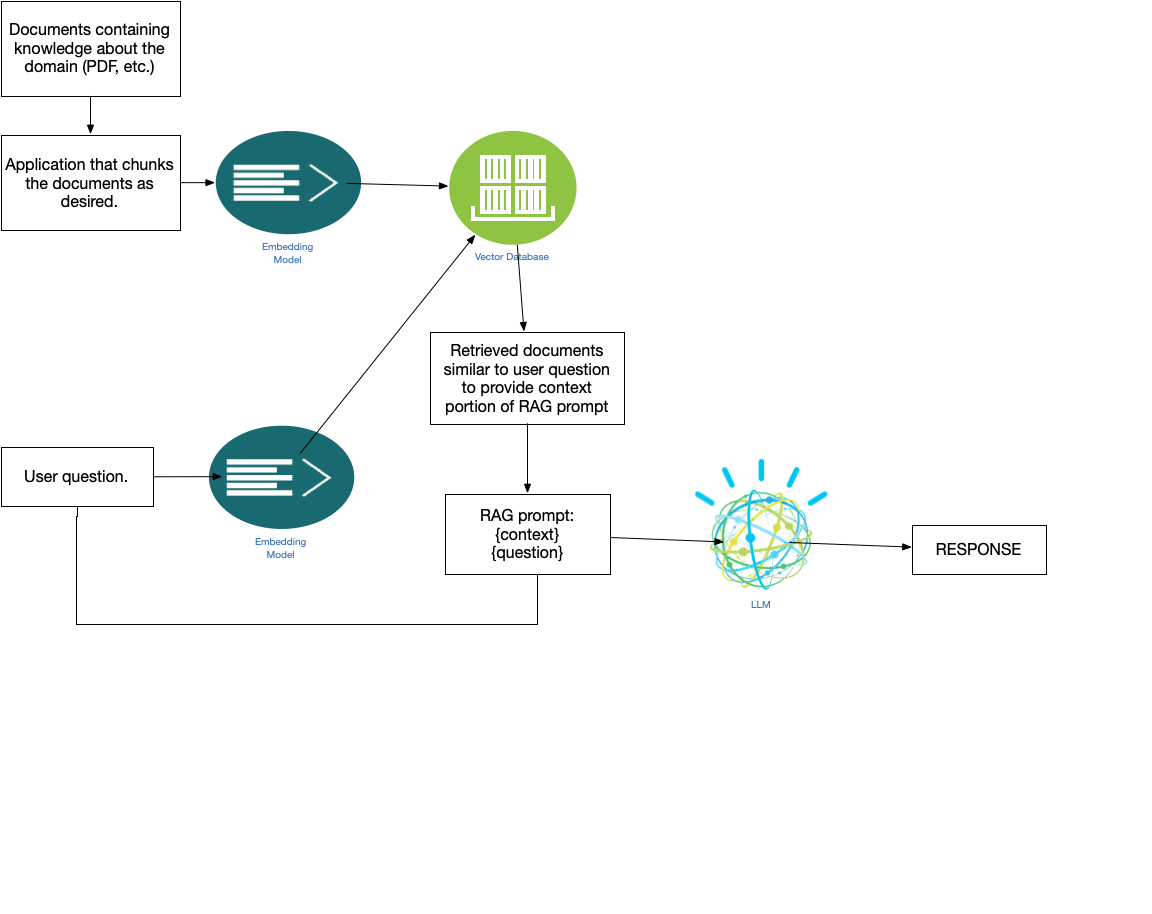

In [36]:
from IPython.display import Image
image_path = "images/RAGDiagram.png"
display(Image(filename=image_path))